In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun
import astropy.units as u

import os
import copy

import numpy as np
import pandas as pd

from funcs.model import big_model, aflare, calculate_specific_flare_flux, aflare
from funcs.flarefit import log_probability

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest
import emcee
import corner

#

In [14]:
def get_incl(lcs):
    v_rot = lcs['rad'].values*2*np.pi*R_sun / (lcs['Prot_d'].values*u.d)
    vsini = lcs['vsini_kms'].values*u.km/u.s
    e_vsini = lcs['e_vsini_kms'].values*u.km/u.s
    sini = (vsini / v_rot ).decompose()
    #print(sini.decompose(), v_rot.to("km/s"))
    # set values larger than 1 to 1 (must be due to uncertainties in Rstar or vsini):
    #sini[sini.decompose() > 1] = 1.
    incl = np.arcsin(sini.decompose())
    lcs["incl"] = incl
    lcs["incl_err"] = (e_vsini / (v_rot * np.sqrt(1. - sini**2))).decompose()
    return lcs

In [15]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
guesses = pd.read_csv(f"{CWD}/data/summary/results.csv")
props = pd.read_csv(f"{CWD}/data/summary/properties.csv")
#lcs.ID = lcs.ID.astype(int)
#guesses.ID = guesses.ID.astype(int)
guesses

,prefix,ID,ED,e_ED,t0,e_t0,dur,e_dur,ampl,e_ampl,Prot,theta_a_init
0,TIC,237880881,6020,298,1331.82418,0.00194,0.77347,0.02975,0.46626,0.01576,8.43,60.0
1,KIC,100004076,10414,886,1358.52754,0.00072,0.49377,0.02388,0.79166,0.06277,8.88,70.0
2,TIC,44984200,3809,135,1588.02740,0.00106,0.65066,0.03073,0.29153,0.00868,2.71,NaN
3,TIC,277539431,4495,394,1641.86831,0.00291,0.89720,0.08459,0.35356,0.03025,4.56,NaN
4,EPIC,212035340,1954494,483655,3437.83750,0.00029,0.05795,0.00631,29.07702,2.06769,4.63,NaN


In [16]:
lcs = lcs.merge(guesses, on=["ID","prefix"], how="outer")
lcs = lcs.merge(props, left_on="ID", right_on="id")

In [17]:
lcs

,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,dist_err,dist_source,rad,tflux,tlum,kflux,klum,gmag,jmag,kmag
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,0.038400,gaia,0.108176,3.319760e-12,1.119535e+29,6.712990e-13,2.263849e+28,17.8356,13.078,11.771
1,212035340,18,llc,30,ktwo,EPIC,generic,K2,M8,3437.00,...,20.512900,mk_dupuy2012,0.115204,6.546160e-13,8.406482e+29,1.394100e-13,1.790276e+29,19.5667,15.894,14.884
2,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,0.143774,gaia,0.275151,3.492650e-11,8.870689e+30,1.272670e-11,3.232358e+30,14.9796,11.530,10.636
3,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,0.027472,gaia,0.142339,6.305290e-11,9.308451e+29,2.018160e-11,2.979395e+29,14.4115,10.309,9.268
4,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,0.106872,gaia,0.145216,5.011190e-11,1.126370e+30,1.380730e-11,3.103479e+29,14.7381,10.630,9.666
5,300741820,8,slc,2,tess,TIC,generic,TESS,NaN,1522.00,...,4.409260,mk_dupuy2012,0.127594,2.711650e-11,1.608939e+30,8.679300e-12,5.149798e+29,15.3277,11.959,11.126


In [18]:
lcs = get_incl(lcs)
lcs.to_csv(f"{CWD}/data/summary/everything.csv", index=False)
target = lcs.iloc[2]
target

ID                            237880881
QCS                                   1
typ                                 slc
cadence_min                           2
mission                            tess
prefix                              TIC
origin                          generic
h_mission                          TESS
SpT                                  M5
view_start                         1331
view_stop                        1333.5
view_min                            560
view_max                            700
BJDoff                          2457000
tstart                           1331.7
ampl_min                            NaN
ampl_max                            NaN
RA                               19.528
Dec                            -62.9831
J                                 11.53
R                                   NaN
Gaia_G                          14.9796
vsini_kms                          14.4
e_vsini_kms                         2.6
Prot_d                          0.35125


In [19]:
from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve
from funcs.custom_detrending import refine_detrended_flux_err
from funcs.multiperiod import remove_sinusoidal, fetch_lightcurve

flck = fetch_lightcurve(target)



t, sflux, model, period = remove_sinusoidal(target, plot=True, save=False)
print(sflux)
F = FlareLightCurve(time=t, detrended_flux=sflux, 
                    detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))
print(F.detrended_flux_err)
flcd = refine_detrended_flux_err(F, mask_pos_outliers_sigma=1.5, 
                                     std_rolling_window_length=15, pad=25)

choice = (t > target.view_start + 1.56) & (t < target.view_stop-1.)
t = t[choice]
flux = sflux[choice]
flux_err = np.nanmean(flcd.detrended_flux_err)
median = np.nanmean(find_iterative_median(F).it_med)
phi = (t - t[0])/target.Prot_d * 2 * np.pi
median

ModuleNotFoundError: No module named 'altaipony'

In [20]:

#pd.DataFrame({"phi":phi,"flux":flux, "t":t,"flux_err":flux_err, "median_":median}).to_csv(f"{target.ID}.csv",index=False)
lc = pd.read_csv(f"{CWD}/data/lcs/{target.ID}.csv")
phi = lc.phi.values
flux = lc.flux.values
flux_err = lc.flux_err.values
t= lc.t.values
median = 615#lc.median_[0]

In [21]:
0.85/np.pi*180

48.70141258611997

(0.8726646259971648, 0.3718561470554695, 0.8338494160107599)

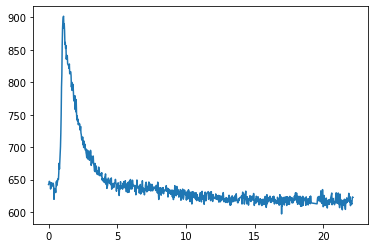

In [22]:

phi_a = (target.t0 - t[0])/target.Prot_d * 2 * np.pi-.3
theta_a = 50*np.pi/180#target.theta_a_init
a = target.ampl*2.2
fwhm = target.dur /target.Prot_d * 2 * np.pi/8
i_mu = target.incl
i_sigma = target.incl_err
#theta_a = i_mu +.1
#phi = np.linspace(0, 30*np.pi, N)
qlum = target.tlum * u.erg/u.s
R = target.rad * R_sun
phi0 = 1.8 * np.pi / 180
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
# m = big_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
#               phi=phi, num_pts=50, qlum=qlum,
#               Fth=Fth, R=R, median=median)
# flare = aflare(phi, phi_a, fwhm, a*median,)
phi_a_max = phi[-1]
plt.plot(phi,flux)
theta_a, i_mu, phi_a

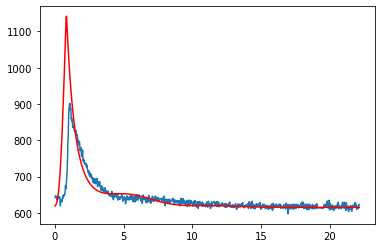

In [12]:
plt.plot(phi,flux)
plt.plot(phi, big_model(phi_a, theta_a, a, fwhm, i_mu, phi0=phi0,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="r", alpha=1,)


### Save inits

In [0]:
with open(f"{CWD}/data/summary/inits.csv", "a") as f:
    firstout = "phi_a,theta_a,a,fwhm,Fth,"

## Run MCMC

In [23]:

inits = np.array([phi_a, theta_a, a, fwhm, i_mu, phi0]) 
pos = inits * (1. + 1e-3 * np.random.randn(32, 6))
nwalkers, ndim = pos.shape

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = f"{target.ID}_MCMC.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "theta_a_min":0, "phi_a_max":phi_a_max}),
                                backend=backend)

In [24]:

sampler.run_mcmc(pos, 2000, progress=True);

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 1/2000 [00:01<42:02,  1.26s/it]

  0%|          | 2/2000 [00:02<41:59,  1.26s/it]

  0%|          | 3/2000 [00:03<42:16,  1.27s/it]

  0%|          | 4/2000 [00:05<42:39,  1.28s/it]

  0%|          | 5/2000 [00:06<43:14,  1.30s/it]

  0%|          | 6/2000 [00:07<43:48,  1.32s/it]

  0%|          | 7/2000 [00:09<44:03,  1.33s/it]

  0%|          | 8/2000 [00:10<44:00,  1.33s/it]

  0%|          | 9/2000 [00:11<44:08,  1.33s/it]

  0%|          | 10/2000 [00:13<44:33,  1.34s/it]

  1%|          | 11/2000 [00:14<45:54,  1.38s/it]

  1%|          | 12/2000 [00:16<45:36,  1.38s/it]

  1%|          | 13/2000 [00:17<48:44,  1.47s/it]

  1%|          | 14/2000 [00:19<48:40,  1.47s/it]

  1%|          | 15/2000 [00:20<46:34,  1.41s/it]

  1%|          | 16/2000 [00:21<46:26,  1.40s/it]

  1%|          | 17/2000 [00:23<45:03,  1.36s/it]

  1%|          | 18/2000 [00:24<44:04,  1.33s/it]

  1%|          | 19/2000 [00:25<44:17,  1.34s/it]

prior inf


  1%|          | 20/2000 [00:27<43:26,  1.32s/it]

prior inf


  1%|          | 21/2000 [00:28<43:15,  1.31s/it]

  1%|          | 22/2000 [00:29<43:19,  1.31s/it]

prior inf


  1%|          | 23/2000 [00:31<44:05,  1.34s/it]

prior inf


  1%|          | 24/2000 [00:32<43:51,  1.33s/it]

prior inf


  1%|▏         | 25/2000 [00:33<43:25,  1.32s/it]

prior inf


  1%|▏         | 26/2000 [00:34<42:13,  1.28s/it]

prior inf
prior inf


  1%|▏         | 27/2000 [00:36<42:20,  1.29s/it]

prior inf


prior inf
prior inf


  1%|▏         | 28/2000 [00:37<42:19,  1.29s/it]

prior inf


prior inf
prior inf


prior inf


  1%|▏         | 29/2000 [00:38<40:53,  1.24s/it]

prior inf
prior inf


  2%|▏         | 30/2000 [00:40<43:08,  1.31s/it]

prior inf


prior inf
prior inf


  2%|▏         | 31/2000 [00:41<43:06,  1.31s/it]

prior inf


prior inf
prior inf


  2%|▏         | 32/2000 [00:42<42:22,  1.29s/it]

prior inf


prior inf
prior inf


prior inf


  2%|▏         | 33/2000 [00:43<41:07,  1.25s/it]

prior inf
prior inf


prior inf


  2%|▏         | 34/2000 [00:45<41:15,  1.26s/it]

prior inf
prior inf


prior inf


  2%|▏         | 35/2000 [00:46<39:32,  1.21s/it]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


prior inf


  2%|▏         | 36/2000 [00:47<37:57,  1.16s/it]

prior inf
prior inf


prior inf
prior inf


prior inf
prior inf


  2%|▏         | 37/2000 [00:48<37:30,  1.15s/it]

prior inf


prior inf


prior inf


prior inf


  2%|▏         | 38/2000 [00:49<36:53,  1.13s/it]

prior inf


prior inf
prior inf


prior inf


  2%|▏         | 39/2000 [00:50<36:39,  1.12s/it]

prior inf


prior inf


  2%|▏         | 40/2000 [00:51<36:50,  1.13s/it]

prior inf
prior inf


prior inf


prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


  2%|▏         | 41/2000 [00:52<35:35,  1.09s/it]

  2%|▏         | 42/2000 [00:53<37:33,  1.15s/it]

prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


  2%|▏         | 43/2000 [00:54<36:03,  1.11s/it]

prior inf


prior inf
prior inf
prior inf
prior inf
prior inf


  2%|▏         | 44/2000 [00:55<34:59,  1.07s/it]

prior inf
prior inf


prior inf
prior inf


prior inf
prior inf


  2%|▏         | 45/2000 [00:57<35:24,  1.09s/it]

prior inf
prior inf
prior inf


prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


  2%|▏         | 46/2000 [00:57<33:46,  1.04s/it]

prior inf
prior inf


prior inf
prior inf


  2%|▏         | 47/2000 [00:59<34:04,  1.05s/it]

prior inf
prior inf


prior inf
prior inf
ll error
prior inf
prior inf


  2%|▏         | 48/2000 [00:59<33:09,  1.02s/it]

prior inf
prior inf


prior inf
prior inf
prior inf


prior inf
prior inf


prior inf
prior inf


  2%|▏         | 49/2000 [01:00<32:53,  1.01s/it]

prior inf
prior inf


  2%|▎         | 50/2000 [01:02<33:49,  1.04s/it]

prior inf
prior inf


prior inf


  3%|▎         | 51/2000 [01:03<35:37,  1.10s/it]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 52/2000 [01:04<33:06,  1.02s/it]

prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf


  3%|▎         | 53/2000 [01:05<32:48,  1.01s/it]

prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf


  3%|▎         | 54/2000 [01:06<31:22,  1.03it/s]

prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf


  3%|▎         | 55/2000 [01:06<30:23,  1.07it/s]

prior inf
ll error


prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 56/2000 [01:07<29:47,  1.09it/s]

prior inf


prior inf
prior inf


  3%|▎         | 57/2000 [01:08<32:23,  1.00s/it]

prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 58/2000 [01:10<33:19,  1.03s/it]

prior inf
prior inf
prior inf


prior inf


prior inf
prior inf
prior inf


  3%|▎         | 59/2000 [01:11<33:32,  1.04s/it]

prior inf
prior inf
prior inf


prior inf
prior inf


prior inf
prior inf
prior inf


  3%|▎         | 60/2000 [01:12<32:36,  1.01s/it]

prior inf
prior inf


prior inf
prior inf


prior inf


  3%|▎         | 61/2000 [01:13<34:17,  1.06s/it]

prior inf
prior inf
prior inf


prior inf
prior inf


  3%|▎         | 62/2000 [01:14<34:33,  1.07s/it]

prior inf
prior inf
prior inf
prior inf


prior inf


prior inf
prior inf


  3%|▎         | 63/2000 [01:15<33:49,  1.05s/it]

prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


  3%|▎         | 64/2000 [01:16<33:37,  1.04s/it]

prior inf


prior inf
prior inf
prior inf
prior inf


  3%|▎         | 65/2000 [01:17<33:08,  1.03s/it]

prior inf
ll error
prior inf


prior inf


prior inf


prior inf
prior inf


  3%|▎         | 66/2000 [01:18<33:32,  1.04s/it]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


prior inf
prior inf


  3%|▎         | 67/2000 [01:19<32:40,  1.01s/it]

prior inf


prior inf
prior inf


prior inf
prior inf


  3%|▎         | 68/2000 [01:20<32:49,  1.02s/it]

prior inf
prior inf
prior inf


prior inf
prior inf


prior inf
prior inf
prior inf


  3%|▎         | 69/2000 [01:21<31:50,  1.01it/s]

prior inf
prior inf


prior inf
prior inf


prior inf


  4%|▎         | 70/2000 [01:22<32:11,  1.00s/it]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


prior inf
prior inf


  4%|▎         | 71/2000 [01:23<31:40,  1.01it/s]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


  4%|▎         | 72/2000 [01:24<31:21,  1.02it/s]

prior inf
prior inf


prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


  4%|▎         | 73/2000 [01:25<30:45,  1.04it/s]

prior inf
prior inf


prior inf
prior inf


prior inf
prior inf


  4%|▎         | 74/2000 [01:26<31:26,  1.02it/s]

prior inf
prior inf


prior inf


prior inf


  4%|▍         | 75/2000 [01:27<32:44,  1.02s/it]

prior inf
prior inf


prior inf
prior inf
prior inf


  4%|▍         | 76/2000 [01:28<33:17,  1.04s/it]

prior inf
prior inf


prior inf
prior inf
prior inf


prior inf


  4%|▍         | 77/2000 [01:29<33:35,  1.05s/it]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


prior inf


prior inf


  4%|▍         | 78/2000 [01:30<32:47,  1.02s/it]

prior inf
prior inf


prior inf
prior inf


prior inf


  4%|▍         | 79/2000 [01:31<33:39,  1.05s/it]

prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 80/2000 [01:32<33:16,  1.04s/it]

prior inf
prior inf
prior inf
prior inf


prior inf
prior inf


  4%|▍         | 81/2000 [01:33<33:32,  1.05s/it]

prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


prior inf
prior inf


  4%|▍         | 82/2000 [01:34<33:58,  1.06s/it]

prior inf


prior inf
prior inf


prior inf
prior inf


prior inf
prior inf
prior inf


  4%|▍         | 83/2000 [01:35<33:16,  1.04s/it]

prior inf
prior inf


prior inf
prior inf
prior inf


prior inf
prior inf
ll error


  4%|▍         | 84/2000 [01:36<32:30,  1.02s/it]

prior inf
prior inf
prior inf


prior inf
prior inf


prior inf
prior inf


  4%|▍         | 85/2000 [01:37<31:57,  1.00s/it]

prior inf


prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


  4%|▍         | 86/2000 [01:38<32:18,  1.01s/it]

prior inf
prior inf
prior inf


prior inf
prior inf


prior inf


  4%|▍         | 87/2000 [01:39<32:34,  1.02s/it]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error


prior inf
prior inf
prior inf
prior inf


  4%|▍         | 88/2000 [01:40<30:55,  1.03it/s]

prior inf
prior inf


prior inf
prior inf
prior inf


  4%|▍         | 89/2000 [01:41<31:56,  1.00s/it]

prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 90/2000 [01:42<31:05,  1.02it/s]

prior inf
prior inf
prior inf


prior inf


prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf


  5%|▍         | 91/2000 [01:43<30:09,  1.05it/s]

prior inf
prior inf


prior inf


prior inf


  5%|▍         | 92/2000 [01:44<32:08,  1.01s/it]

prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


  5%|▍         | 93/2000 [01:45<31:18,  1.01it/s]

prior inf
prior inf
prior inf
prior inf


prior inf
prior inf


prior inf


  5%|▍         | 94/2000 [01:46<30:45,  1.03it/s]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 95/2000 [01:47<30:15,  1.05it/s]

prior inf
prior inf


prior inf
prior inf


prior inf
prior inf
prior inf


  5%|▍         | 96/2000 [01:48<31:05,  1.02it/s]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


prior inf


  5%|▍         | 97/2000 [01:49<30:56,  1.02it/s]

prior inf


prior inf


prior inf


  5%|▍         | 98/2000 [01:50<33:42,  1.06s/it]

prior inf


prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 99/2000 [01:51<33:24,  1.05s/it]

prior inf


prior inf
prior inf
prior inf


  5%|▌         | 100/2000 [01:52<33:12,  1.05s/it]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


prior inf
ll error


  5%|▌         | 101/2000 [01:53<31:39,  1.00s/it]

prior inf
prior inf


prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


  5%|▌         | 102/2000 [01:54<31:21,  1.01it/s]

prior inf
prior inf
prior inf
prior inf


prior inf


prior inf
prior inf


  5%|▌         | 103/2000 [01:55<31:33,  1.00it/s]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


prior inf
prior inf


  5%|▌         | 104/2000 [01:56<31:19,  1.01it/s]

prior inf
prior inf


prior inf
prior inf


  5%|▌         | 105/2000 [01:57<31:18,  1.01it/s]

prior inf
prior inf
prior inf
prior inf


prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 106/2000 [01:58<31:04,  1.02it/s]

prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


  5%|▌         | 107/2000 [01:59<31:26,  1.00it/s]

In [14]:
target.ID

In [13]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['flare peak\nlongitude', 'flare\nlatitude', 'relative\namplitude', 'flare\nFWHM', 'inclination \nrad]', 'phi0\n[rad]']
for j in range(ndim):
    ax = axes[j]
    ax.plot(samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
#plt.savefig(f"{target.prefix}{target.ID}_5000_fixed.png",dpi=300)

In [14]:

flat_samples = sampler.get_chain(discard=1600, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels)# truths=[phi_a, theta_a, a, fwhm,i_mu, phi0]);
#plt.savefig(f"{target.prefix}{target.ID}_5000_corner_disc1000_fixed.png",dpi=300)

In [17]:
.75/np.pi*180-1.1/np.pi*180 #pm 10
1/np.pi*180

In [15]:
inds = np.random.randint(len(flat_samples), size=500)
plt.figure(figsize=(10,8))
#plt.scatter(flck.time, flck.flux, s=1)
plt.scatter(phi, flux, s=10, c="k")
#plt.errorbar(phi, flux, yerr=flux_err, fmt=".k", capsize=0)

for ind in inds:
    sample = flat_samples[ind]
    phi_a, theta_a, a, fwhm, i, phi0 = sample
   # plt.plot(phi, aflare(phi, phi_a, fwhm, a*median)+ median, c="grey", alpha=0.05, linewidth=3)
    plt.plot(phi, big_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median), c="r", alpha=0.5,)
#plt.plot(phi, flare+median, c="r",linewidth=1)
plt.legend(fontsize=14)
plt.xlabel("time")
plt.ylabel("flux");
#plt.savefig(f"{target.prefix}{target.ID}_5000_flarefit_disc1000_fixed.png",dpi=300)

In [0]:
samples = sampler.chain[:, 10:, :].reshape((-1, ndim))
#samples[:, 2] = np.exp(samples[:, 2])
t0_mcmc, dur_mcmc, ampl_mcmc, c, d, e = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
t0_mcmc, dur_mcmc, ampl_mcmc

In [0]:
e_t0 = (t0_mcmc[1] + t0_mcmc[2])/2.
e_dur = (dur_mcmc[1] + dur_mcmc[2])/2.
e_ampl = (ampl_mcmc[1] + ampl_mcmc[2])/2.

In [0]:

def ED(t, t0, dur, ampl, median):
    x = t * 60.0 * 60.0 * 24.0
    return np.sum(np.diff(x) * aflare(t, t0, dur, ampl)[:-1]) / (dur * 6 * median)

In [0]:

def t0_ED(x):
    return ED(flc.time, x, dur_mcmc[0], ampl_mcmc[0], median)
def dur_ED(x):
    return ED(flc.time, t0_mcmc[0], x, ampl_mcmc[0], median)
def ampl_ED(x):
    return ED(flc.time, t0_mcmc[0], dur_mcmc[0], x, median)
def median_ED(x):
    return ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], x)
E_t0 = np.sum(derivative(t0_ED, t0_mcmc[0], dx=e_t0/10.)**2 * e_t0**2)
E_dur = np.sum(derivative(dur_ED, dur_mcmc[0], dx=e_dur/10.)**2 * e_dur**2)
E_ampl = np.sum(derivative(ampl_ED, ampl_mcmc[0], dx=e_ampl/10.)**2 * e_ampl**2)
E_median = np.sum(derivative(median_ED, median, dx=e_median/10.)**2 * e_median**2)
np.sqrt(E_t0 + E_dur + E_ampl + E_median), E_t0, E_dur, E_ampl, E_median

In [0]:
check_e_median = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)**2 / median**2 * e_median**2
assert E_median == pytest.approx(E_median,rel=1e-4)
e_median, median

In [0]:
EDval = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)
e_ED = np.sqrt(E_t0 + E_dur + E_ampl + E_median)
EDval,e_ED